# 02477 Bayesian machine learning - Exercise 10

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb

snb.set_style('darkgrid')
snb.set(font_scale=1.5)

The purpose of this exercise is to become familiar with variational inference and to demystify the calculations involved.

In this exercise, we will analyze a very simple Bayesian model in two ways. First, we will derive the exact posterior distribution and the exact marginal likelihood analytically. Next, we derive a variational approximation and compare the approximate results to the exact results. This also provides an opportunity the practice some of the basic concepts of probabilistic calculations, i.e. manipulating distribution using the sum and product rules.


The exercise is divided into 4 parts:

- Part 0: Motivation for the choice of toy example


- Part 1: Exact inference


- Part 2: Variational inference and CAVI updates


- Part 3: The lower bound


### Part 0: Motivation for the toy example


In statistics and machine learning, a **sparse** vector is a vector, where the majority of its entries is exactly equal to zero. For example, 

$$\mathbf{x} = \begin{bmatrix} 0 & 0 & 2.3 & 0 & 4.7 & 0 & 0\end{bmatrix}$$

is a sparse vector.  **Sparsity** is a very efficient tool for tackling high-dimensional problems. Assuming sparsity often allows us to solve high-dimensional regression problems, where the number of features $D$ is much larger than then number of observations $N$, i.e. $D \gg N$. Informally, this works because the sparsity mechanism allows the models to ignore irrelevant or noisy features automatically. Sparsity can also play a key role in interpretability.

In classical machine learning, $\ell_1$-regularization (LASSO) is a common way to introduce sparsity. In the Bayesian world, there are several ways to model sparsity, incl. **automatic relevance determination**, **Horseshoe priors** and **spike-and-slab priors**.

The so-called spike-and-slab prior is very easy to understand from a generative perspective. Suppose we impose such a prior distribution on a parameter $w$, then the generative process goes as follows:

1. We "flip a coin" with probability $p_0$ to determine whether our parameter $w$ is zero ($s = 0$) or non-zero ($s = 1$):

$$s \sim \text{Ber}(p_0)$$

2. If it turns out to be non-zero ($s =1$), we sample the coefficient from a Gaussian (or another distributions).

$$w \sim \mathcal{N}(0, 1)$$

3. We define the parameter $\tilde{w}$ as

$$\tilde{w} = s \cdot w$$

This process forces $w$ to be exactly zero if $s = 0$ irregardless of the value of $w$.

This prior is called the spike-and-slab prior because the marginal distribution of $w$ is a mixture of a "spike" at $\tilde{w} = 0$ and a Gaussian (the slab). 








### Part 1: Exact inference in a toy example

We will work with a very simple toy model with a Gaussian likelihood and a spike-and-slab prior on the mean of the Gaussian. Let $t \in \mathbb{R}$ be an observation, let $s \in \left\lbrace 0, 1 \right\rbrace$ be a binary variable and let $w \in \mathbb{R}$ be a parameter, then

$$\begin{align*}
t = s\cdot w + e,
\end{align*}
$$

where $e \sim \mathcal{N}(0, \sigma^2)$ is additive Gaussian noise. Here the binary variable $s \in \left\lbrace 0, 1\right\rbrace$ indicates whether the parameter $w$ is "active" or not:

$$
\begin{align*}
t|s=0 &\sim \mathcal{N}(0, \sigma^2)\\
t|s=1 &\sim \mathcal{N}(w, \sigma^2)
\end{align*}
$$

In other words, $s$ dictates whether the recorded observation $t$ is generated by signal + noise, i.e. $t = w + e$, or by pure noise, i.e. $t = e$. Assuming a Gaussian prior on $w$ and a Bernoulli prior on $s$, we can write the joint model as follows

$$\begin{align*}
p(t, s, w) &= p(t|s, w)p(s)p(w)\\
&= \mathcal{N}(t|sw, \sigma^2)\text{Ber}(s|p_0)\mathcal{N}(w|0, \kappa^2)
\end{align*}
$$

Note that the model only contains a single observation $t$, i.e. $N = 1$. We can easily extend it and the all results to $N$ observations, but we stick to $N = 1$ to keep to derivations simple as possible.


In this exercise, we will focus on the marginal posterior $p(s|t)$, which can be interpreted as the probability of the parameter $w$ is "active", i.e. non-zero, after seeing the data. This quantity is therefore often used for feature and model selection. 

As usual, we obtain the joint posterior from Bayes' rule

$$
\begin{align*}
p(w, s|t) = \frac{p(t|s, w)p(s)p(w)}{p(t)}.
\end{align*}
$$

We can easily obtain the marginal posterior $p(s|t)$ from the joint posterior, but first, we will deal with the marginal likelihood $p(t)$.


### Part 1.1: The marginal likelihood

Because this model is very simple, we can derive the normalization constant, i.e. $p(t)$, in closed form by applying the sum rule to marginalize over $s$ and $w$.

**Task 1:** Show that the marginal likelihood $p(t)$ is given by

$$p(t) =  (1-p_0)\mathcal{N}(t|0, \sigma^2) + p_0\mathcal{N}(t|0, \sigma^2 + \kappa^2)\tag{1}$$


*Hints*
1. The marginal distribution $p(t)$ can be obtained from the joint distribution $p(t, s, w$) by marginalizing over $s$ and $w$.
2. The following integral $\int \mathcal{N}(t|sw, \sigma^2)\mathcal{N}(w|0, \kappa^2) \text{d}w = \mathcal{N}(t|0, \sigma^2 + s^2 \kappa^2)$ will be useful. It is follows from eq. (2.115) in Bishop.
3. Don't hesitate to ask for help if you are stuck.



**Task 1: Solution**

\begin{align*}
p(t) &= \int \sum_{s \in \left\lbrace 0, 1\right\rbrace} p(t|s, w)p(s)p(w) \text{d}w &&\text{(Sum rule)}\\
%
&= \int \sum_{s \in \left\lbrace 0, 1\right\rbrace} \mathcal{N}(t|sw, \sigma^2)\text{Ber}(s|p_0)\mathcal{N}(w|0, \kappa^2) \text{d}w &&\text{(Def. of model)}\\
%
&= \sum_{s \in \left\lbrace 0, 1\right\rbrace} \int \mathcal{N}(t|sw, \sigma^2)\mathcal{N}(w|0, \kappa^2) \text{d}w\text{Ber}(s|p_0) &&\text{(Linearity of integrals)}\\
%
&=  \sum_{s \in \left\lbrace 0, 1\right\rbrace} \mathcal{N}(t|0, \sigma^2 + s^2 \kappa^2)\text{Ber}(s|p_0)&&\text{(Using eq. (2.115) in Bishop)}\\
%
&=  (1-p_0)\mathcal{N}(t|0, \sigma^2) + p_0\mathcal{N}(t|0, \sigma^2 + \kappa^2),
\end{align*}



where the result 


\begin{align*}
\int \mathcal{N}(t|sw, \sigma^2)\mathcal{N}(w|0, \kappa^2) \text{d}w = \mathcal{N}(t|0, \sigma^2 + s^2 \kappa^2)
\end{align*}


is a standard Gaussian integral from eq. (2.115) in Bishop.


### Part 1.2: The marginal posterior p(s|t)


Next, we will derive the joint posterior $p(w, s|t)$ using Bayes rule

$$
\begin{align*}
p(w, s|t) &= \frac{p(t|s, w)p(s)p(w)}{p(t)}\\
&= \frac{\mathcal{N}(t|sw, \sigma^2)\text{Ber}(s|p_0)\mathcal{N}(w|0, \kappa^2)}{(1-p_0)\mathcal{N}(t|0, \sigma^2) + p_0\mathcal{N}(t|0, \sigma^2 + \kappa^2)} \\
&= \frac{\mathcal{N}(t|sw, \sigma^2)\text{Ber}(s|p_0)\mathcal{N}(w|0, \kappa^2)}{Z_t}, 
\end{align*}
$$

where we have defined $Z_t \equiv (1-p_0)\mathcal{N}(t|0, \sigma^2) + p_0\mathcal{N}(t|0, \sigma^2 + \kappa^2)$ to ease the notation.


Once we have the joint posterior, we can easily compute the marginal posterior $p(s|t)$ by marginalizing over $w$ in $p(w, s|t)$


\begin{align*}
p(s|t) &= \int \frac{\mathcal{N}(t|sw, \sigma^2)\text{Ber}(s|p_0)\mathcal{N}(w|0, \kappa^2)}{Z_t} \text{d}w\\
%
&= \frac{\int  \mathcal{N}(t|sw, \sigma^2)\mathcal{N}(w|0, \kappa^2)\text{d}w \,\text{Ber}(s|p_0)}{Z_t}\\
%
&= \frac{\mathcal{N}(t|0, \sigma^2 + s^2 \kappa^2) \text{Ber}(s|p_0)}{Z_t}\tag{a}
\end{align*}


where we have used eq. $(2.115)$ again in the last line. We could obtain $p(w|t)$ in a similar fashion by marginalizing over $s$ in $p(w, s|t)$.





**Task 2**: Use the equation above to argue that the posterior probability $p(s=1|t)$ is given by:

$$ p(s=1|t) =\frac{ p_0\mathcal{N}(t|0, \sigma^2 + \kappa^2)}{Z_t}$$

*Hints*
1. This is meant to be a very easy and straight-forward question


**Task 2: Solution**

Using $\text{Ber}(s=1|p_0) = p_0$ in eq. (a) and simplifying gives the desired result.

### Part 1.3: Visualizing the results

Assuming $\sigma^2 = 0.1$ and $\kappa^2 = 1$, let's visualize $p(s=1|t)$ as a function of $t$ for various values of $p_0$

Task 3: Plot $p(s=1|t)$ as a function of $t \in \left[-3, 3 \right]$ for the following three different values of $p_0 \in \left\lbrace 0.1, 0.5, 0.9 \right\rbrace$

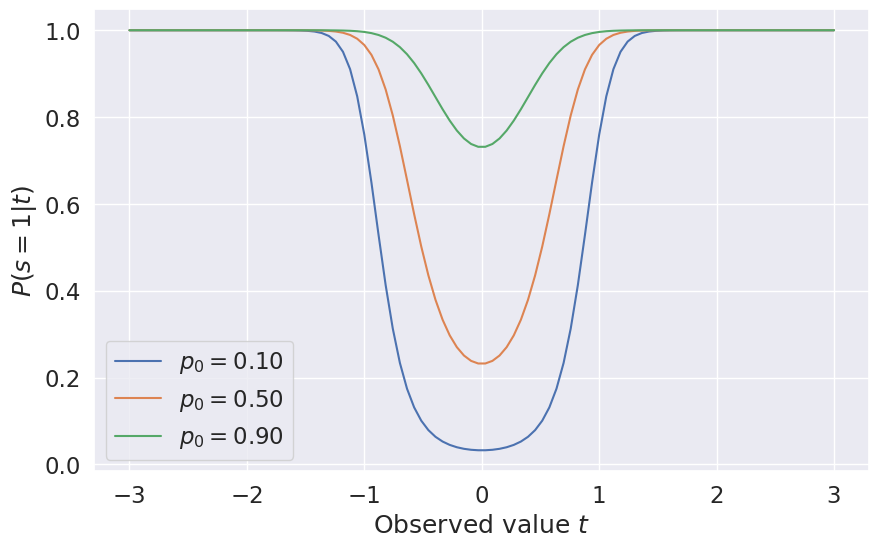

In [4]:
# definition of Bernoulli and Gaussian distributions
npdf = lambda x, m, v: np.exp(-(x-m)**2/(2*v))/np.sqrt(2*np.pi*v)
ber = lambda s, p: p**s*(1-p)**(1-s)

# values for t
t_grid = np.linspace(-3, 3, 100)

# fixed hyperparameters
kappa2 = 1
sigma2 = 0.1

##################################################################################
# Solution to task 3
##################################################################################

# marginal likelihood
def marginal_likelihood(t, p0, sigma2, kappa2):
    return (1-p0)*npdf(t, 0, sigma2) + p0*npdf(t, 0, sigma2+kappa2)

# compute posterior marginal probability of p(s=1|t)
def exact_marginal_s1(t, p0, sigma2, kappa2):
    Zt = marginal_likelihood(t, p0, sigma2, kappa2)
    return p0*npdf(t, 0, sigma2 + kappa2)/Zt

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for p0 in [0.1, 0.5, 0.9]:

    # plot
    ax.plot(t_grid, exact_marginal_s1(t_grid, p0, sigma2, kappa2), label='$p_0 = %3.2f$' % p0)
    ax.legend()
    ax.set_xlabel('Observed value $t$')
    ax.set_ylabel('$P(s=1|t)$');


**Questions**

1) What happens to the posterior $p(s|t)$ probability as $|t|$ increases? Use the model equation $t = s\cdot w + e$ to explain why this make sense. *Hint: Which values to we expect for $t$ when $s=0$?*
* The posterior probability goes towards 1, which makes sense since $t = s\cdot w + e$ where e is standard gaussian noise i.e. when |t| is large the probability the s = 1 is high because we need the signal w to achieve the high absolute value of t value.

2) What happens when $p_0$ is decreased? and why?
   * Then the posterior probability $p(s=1|t)$ is decreased because $$ p(s=1|t) =\frac{ p_0\mathcal{N}(t|0, \sigma^2 + \kappa^2)}{Z_t}$$

### Part 2: Variational inference

In this part, we will now set-up a variational approximation $q(s,w)$ to approximate the posterior distribution $p(s, w|t) \approx q(s,w)$. We will use the following factorized variational family

$$
\begin{align*}
q(s, w) = q(s)q(w) = \text{Ber}(s|\hat{p}) \mathcal{N}(w|\hat{m}, \hat{v})
\end{align*}
$$


We now assume that the $s$ and $w$ are independent in the posterior and that the posterior distributions of $s$ and $w$ are a Bernoulli distribution (with parameter $\hat{p}$) and a Gaussian distribution (with parameters $\hat{m}$ and $\hat{v}$), respectively. Thus, the task of searching for a 'good' approximation is reduced to searching for a good set of **variational parameters** $(\hat{p}, \hat{m}, \hat{v})$.

Our goal is to identify the distribution $q(s, w|\hat{p}, \hat{m}, \hat{v})$ that minimizes the KL-divergence between the exact posterior $p(s,w|t)$ and the approximation. Thus, given some observation $t$, we want to determine the variational parameters $\hat{p}$, $\hat{m}$, and $\hat{v}$. 

In general, we can find the optimal approximation (as measured by the KL divergence) by maximizing the **evidence lowerbound** (ELBO) $\mathcal{L}(q)$

$$\mathcal{L}(q) = \mathbb{E}_q\left[\ln p(t, s, w)\right] - \mathbb{E}_q\left[\ln q(s, w)\right]$$

wrt. the variational parameters $\hat{m}$, $\hat{v}$ and $\hat{p}$. 

However for factorized variational families, we can determine the optimal approximation for $q^*(s)$ and $q^*(w)$ using the following equations (as discussed in lecture 9 and in Sec. 10.1. in Bishop)

$$
\begin{align*}
\ln q^* (w) &= \mathbb{E}_{q(s)}\left[ \ln \left(p(t|s, w)p(s)p(w)\right)\right] + K_w\\
\ln q^*(s) &= \mathbb{E}_{q(w)}\left[ \ln \left(p(t|s, w)p(s)p(w)\right)\right] + K_s,
\end{align*}
$$
where $K_w$ and $K_s$ are constants.

We will now go through these calculations in details. 

### Part 2.1: Optimal distribution for $q(w)$

Our starting point is the equation for $\ln q^* (w)$. Similar to the derivation of the Gibbs sampler in exercise 8, we focus on terms that depends on $w$ and absorb the rest an the additive constant. Let's plug in the model distributions and simplify:


\begin{align*}
\ln q^* (w) &= \mathbb{E}_{q(s)}\left[ \ln p(t|s, w)p(s)p(w)\right] + K\\
&=  \mathbb{E}_{q(s)}\left[\ln \mathcal{N}(t|sw, \sigma^2)\text{Ber}(s|p_0)\mathcal{N}(w|0, \kappa^2)\right] + K\\
&=  \mathbb{E}_{q(s)}\left[\ln \mathcal{N}(t|sw, \sigma^2)\right] + \mathbb{E}_{q(s)}\left[ \ln \text{Ber}(s|p_0)\right] + \mathbb{E}_{q(s)}\left[ \ln \mathcal{N}(w|0, \kappa^2)\right] +K\\
&=  \mathbb{E}_{q(s)}\left[\ln \mathcal{N}(t|sw, \sigma^2)\right] +  \ln \mathcal{N}(w|0, \kappa^2) + K' \tag{4}
\end{align*}


where we have absorbed the term $ \mathbb{E}_{q(s)}\left[ \ln \text{Ber}(s|p_0)\right]$ into the constant because it is independent of $w$. We also used the fact that $\ln \mathcal{N}(w|0, \kappa^2)$ is independet of $q(s)$.

***Task 4***: For $q(z) = \text{Ber}(z|\hat{p})$, show that $\mathbb{E}_q\left[z\right] = \hat{p}$ and $\mathbb{E}_q\left[z^2\right] = \hat{p}$.

*Hint*: The definition of the $n$-th moment of discrete random variable with distribution $p$ is $\mathbb{E}_p\left[z^n\right] = \sum_{z} z^n p(z)$.

***Solution task 4***

For the first moment, we have

\begin{align*}
\mathbb{E}_q\left[z\right] = \sum_{z \in \left\lbrace 0 ,1 \right\rbrace} z q(z) = 0 q(0) + 1 q(1) = 0 (1-\hat{p}) + 1 \hat{p} = \hat{p}
\end{align*}

Similarly, for the second moment, we have

\begin{align*}
\mathbb{E}_q\left[z^2\right] = \sum_{z \in \left\lbrace 0 ,1 \right\rbrace} z^2 q(z) = 0^2 q(0) + 1^2 q(1) = 0^2 (1-\hat{p}) + 1^2 \hat{p} = \hat{p}
\end{align*}


**Task 5**: Insert the expressions for the Gaussian densities into eq. (4) and show that it simplifies to


$$
\ln q^* (w) = - \frac{1}{2} \left[\frac{1}{\sigma^2}\hat{p} +  \frac{1}{\kappa^2}\right] w^2 + \frac{1}{\sigma^2} \hat{p} t w  + K' \tag{5}
$$

*Hints:*
1. Absorb all terms independent of $w$ into the constant (e.g. normalization terms from the Gaussian densities)
2. Remember that expectations are linear
3. The results of task 4 will come in handy
4. Collect all terms that depends on $w^2$ and collect all terms that depends on $w$





**Solution for task 5**


$$
\begin{align*}
\ln q^* (w) &= \mathbb{E}_{q(s)}\left[-0.5 \ln (2\pi\sigma^2) - \frac{1}{2\sigma^2} \left(t-sw\right)^2\right] +  - \frac{1}{2}\log(2\pi\kappa^2) - \frac{1}{2\kappa^2} w^2 + K&&\text{(def. of Gaussians)}\\
%
&= \mathbb{E}_{q(s)}\left[ - \frac{1}{2\sigma^2} \left(t-sw\right)^2\right]  -  \frac{1}{2\kappa^2} w^2 + K&&\text{(absorb constants)}\\
%
&=  - \frac{1}{2\sigma^2} \mathbb{E}_{q(s)}\left[\left(t-sw\right)^2\right]  -  \frac{1}{2\kappa^2} w^2 + K\\
%
&=  - \frac{1}{2\sigma^2} \mathbb{E}_{q(s)}\left[t^2 + s^2 w^2 - 2tsw\right]  -  \frac{1}{2\kappa^2} w^2 + K\\
%
&=  - \frac{1}{2\sigma^2}t^2  - \frac{1}{2\sigma^2} \mathbb{E}_{q(s)}\left[ s^2 \right] w^2 + \frac{1}{\sigma^2} \mathbb{E}_{q(s)}\left[s\right] t w  -  \frac{1}{2\kappa^2} w^2 + K&&\text{(linearity of expectations)}\\
%
&=  - \frac{1}{2\sigma^2} \hat{p} w^2 + \frac{1}{\sigma^2} \hat{p} tw  -  \frac{1}{2\kappa^2} w^2 + K\\
%
&=  - \frac{1}{2} \left[\frac{1}{\sigma^2}\hat{p} +  \frac{1}{\kappa^2}\right] w^2 + \frac{1}{\sigma^2} \hat{p} t w  + K\\
\end{align*}
$$


By inspection of eq. (5), we recognize the functional form of $\ln q(w)$ as a quadratic function of $w$ and thus, we conclude that $q(w)$ must be a Gaussian distribution. (We already made that assumption, but now we proved that it is optimal)


Consider the log density for a generic Gaussian distribution with mean $m$ and variance $v$
$$
\begin{align*}
\ln \mathcal{N}(w|m,v) &= -\frac{1}{2}\log(2\pi v) -\frac{1}{2v}(w-m)^2\\
&= -\frac{1}{2v}(w^2 + m^2 - 2wm) + K\\
&= -\frac{1}{2v}w^2 + \frac{m}{v} w + K' \tag{6}
\end{align*}
$$

**Task 6**: By comparing the coefficients for $w$ and $w^2$ in eq. (5) and (6), show that the mean $\hat{m}$ and variance $\hat{v}$ of $q(w) = \mathcal{N}(w|\hat{m}, \hat{w})$ are given by

$$
\begin{align*}
\hat{m} &=  \frac{\hat{v}}{\sigma^2} \hat{p} t \tag{7}
\end{align*}
$$
$$
\begin{align*}
\hat{v} &=\frac{1}{\frac{1}{\sigma^2}\hat{p} +  \frac{1}{\kappa^2}}\tag{8}
\end{align*}
$$


**Solution for task 6**


We will identify the mean $\hat{m}$ and variance $\hat{v}$ by matching coefficients for $w^2$ and $w$

$$
\begin{align*}
-\frac{1}{2\hat{v}}w^2 = - \frac{1}{2} \left[\frac{1}{\sigma^2}\hat{p} +  \frac{1}{\kappa^2}\right] w^2 \quad\iff\quad \frac{1}{\hat{v}} = \frac{1}{\sigma^2}\hat{p} +  \frac{1}{\kappa^2} \quad \iff \quad \hat{v} = \left[\frac{1}{\sigma^2}\hat{p} +  \frac{1}{\kappa^2}\right]^{-1}
\end{align*}
$$

and 

$$
\begin{align*}
\frac{\hat{m}}{\hat{v}} w = \frac{1}{\sigma^2} \hat{p} t w \quad\iff \quad \frac{\hat{m}}{\hat{v}} = \frac{1}{\sigma^2} \hat{p} \quad\iff\quad \hat{m} =  \frac{\hat{v}}{\sigma^2} \hat{p} t
\end{align*}
$$

Notice that the optimal values for $\hat{m}$ and $\hat{v}$ depend on $\hat{p}$, i.e. the variational parameter for $q(s)$.

This concludes the calculation for $q(w) = \mathcal{N}(w|\hat{m}, \hat{v})$. Let's do the same for $q(s)$.

### Part 2.2: The optimal distribution for $q(s)$

We will use the same strategy for $q(s)$ and now focus on terms that depends on $s$

$$
\begin{align*}
\ln q^*(s) &= \mathbb{E}_{q(w)}\left[ \ln p(t|s, w)p(s)p(w)\right] + K\\
%
&=  \mathbb{E}_{q(w)}\left[\ln \mathcal{N}(t|sw, \sigma^2)\text{Ber}(s|p_0)\mathcal{N}(w|0, \kappa^2)\right] + K\\
%
&=  \mathbb{E}_{q(w)}\left[\ln \mathcal{N}(t|sw, \sigma^2) \right] + \mathbb{E}_{q(w)}\left[\ln \text{Ber}(s|p_0)\right] + \mathbb{E}_{q(w)}\left[ \ln \mathcal{N}(w|0, \kappa^2)\right] + K\\
%
&=  \mathbb{E}_{q(w)}\left[\ln \mathcal{N}(t|sw, \sigma^2) \right] + \ln \text{Ber}(s|p_0) + K',
\end{align*}
$$

where we have absorbed to term $\mathbb{E}_{q(w)}\left[ \ln  \mathcal{N}(w|0, \kappa^2)\right]$ into the constant because it is independent of $s$.

**Task 7**: Show that $\ln q^*(s)$ is given by

\begin{align*}
\ln q^*(s) &= -s^2\frac{1}{2\sigma^2}\left[\hat{m}^2 + \hat{v}\right] + ts \frac{1}{\sigma^2}  \hat{m} + (1-s)  \ln(1-p_0) + s \ln(p_0) + K \tag{9}
\end{align*}

*Hint*: The first two moments of a Gaussian are $\mathbb{E}_{q(w)}\left[w\right] = \hat{m}$ and $\mathbb{E}_{q(w)}\left[w^2\right] = \hat{m}^2 + \hat{v}$




***Solution to task 7***:


Substituting in the distributions and simplifying yields

$$
\begin{align*}
\ln q^*(s) &=  \mathbb{E}_{q(w)}\left[-0.5 \ln (2\pi\sigma^2) - \frac{1}{2\sigma^2} \left(t-sw\right)^2\right] + (1-s) \ln(1-p_0) + s \ln(p_0)+ K'\\
%
&=  \mathbb{E}_{q(w)}\left[- \frac{1}{2\sigma^2} \left(t-sw\right)^2\right] + (1-s) \ln(1-p_0) + s \ln(p_0) + K''\\
%
&= - \frac{1}{2\sigma^2}  \mathbb{E}_{q(w)}\left[\left(t-sw\right)^2\right] + (1-s) \ln(1-p_0) + s \ln(p_0)  + K''\\
%
&= - \frac{1}{2\sigma^2}  \mathbb{E}_{q(w)}\left[t^2 + s^2w^2 - 2tsw\right] + (1-s) \ln(1-p_0) + s \ln(p_0) + K'''\\
%
&= -s^2\frac{1}{2\sigma^2}  \mathbb{E}_{q(w)}\left[w^2\right] + ts \frac{1}{\sigma^2}  \mathbb{E}_{q(w)}\left[w\right] + (1-s) \ln(1-p_0) + s \ln(p_0)  + K''''\\
\end{align*}
$$

Using standard moments of Gaussians, i.e. $\mathbb{E}_{q(w)}\left[w\right] = \hat{m}$ and $\mathbb{E}_{q(w)}\left[w^2\right] = \hat{m}^2 + \hat{v}$, we get

$$
\begin{align*}
\ln q^*(s) &= -s^2\frac{1}{2\sigma^2}\left[\hat{m}^2 + \hat{v}\right] + ts \frac{1}{\sigma^2}  \hat{m} + (1-s)  \ln(1-p_0) + s \ln(p_0) + K'''' 
\end{align*}
$$


***Normalizing the distribution $q^*(s)$***


We can now calculate

$$
\begin{align*}
\ln q^*(s=0) &= \ln(1-p_0) + K\\
\ln q^*(s=1) &= -\frac{1}{2\sigma^2}\left[\hat{m}^2 + \hat{v}\right] + t \frac{1}{\sigma^2}  \hat{m} + \ln(p_0) + K
\end{align*}
$$


Since $q^*(s)$ is a Bernoulli distribution with parameter $\hat{p}$ and $q^*(s=0) + q^*(s=1) = 1$, we know that

$$
\begin{align*}
\hat{p} = q^*(s=1) &= \frac{q^*(s=1)}{q^*(s=0) + q^*(s=1)} \tag{10}
\end{align*}
$$

Therefore, we can compute $\hat{p}$ by exponentiating and summing over $s$ in eq. (9) to normalize it.
Again, we notice that the optimal value for $\hat{p}$ depends on the variational parameters of $q(w)$.




### Part 2.3: Fixed-point algorithms

We now have a set of equations for $q(w)$ that depends on $q(s)$ and vice versa. 
We can now use eq. (7), (8), and (10) to implement a simple fixed-point algorithm for fitting the variational approximation. This means that we inialize $\hat{p}$, $\hat{m}$ and $\hat{v}$ and we simply iterate the three equations until we reach convergence.

**Task 8**: Complete the function *fit_approximation* below using eq. (7), (8) and (10).



In [11]:
def fit_approximation(t, p0, sigma2, kappa2, max_itt=50, conv_tol=1e-12, verbose=False):
    """ implements a fixed point algorithm for estimating phat, mhat and vhat

        The function iterates the update equations (7), (8) and (10) for a maximum of max_itt iterations or until a convergece tolerance of conv_tol is reached.
        That is, we declare convergence of the sum of squares for the variational parameters between two consequtive iterations is below conv_tol.
    
    """
    
    # initialize variational parameters
    mhat = 0
    vhat = 1
    phat = 0.5
    
    # for convergence testing
    old_values = np.array([mhat, vhat, phat])
    
    # iterate
    for itt in range(max_itt):
                
        # updaet vhat
        vhat = 1/(phat/sigma2 + 1/kappa2)
        
        # update mhat?
        mhat = vhat/sigma2*phat*t
        
        s0 = np.log(1-p0)
        s1 = -1/(2*sigma2)*(mhat**2+vhat) +  t/sigma2*mhat + np.log(p0)
        
        # update phat
        phat = 1/(np.exp(s0-s1)+1)
        
        # check convergence
        values = np.array([mhat, vhat, phat])
        if np.sum((values-old_values)**2) < conv_tol:
            if verbose:
                print('Converged in %d iterations' % itt)
            break
        
        old_values = values

    return phat, mhat, vhat
        
t = 0.1    
    
phat, mhat, vhat = fit_approximation(t, p0=0.5, sigma2=0.1, kappa2=1, verbose=True)

Converged in 27 iterations


### Part 2.4: Comparing the approximation to the exact posterior

***Task 9***: Repeat the plots from Part 1.3, but compute and plot the the variational approximation $q(s)$ on top. Repeat the plot for $p_0 \in \left\lbrace 0.1, 0.5, 0.9\right\rbrace$.

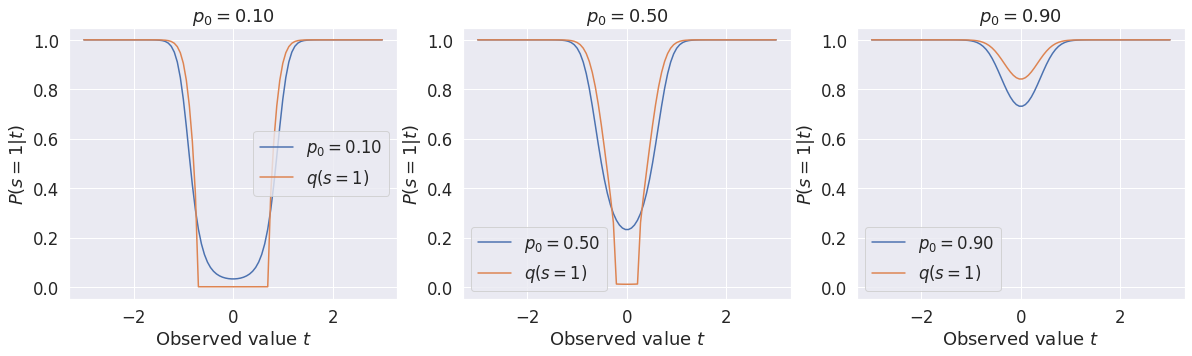

In [44]:
##############################
### Solution task 9
##############################
colors = snb.color_palette()

# plot
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, p0 in enumerate([0.1, 0.5, 0.9]):
    
    # compute values of the approximation for each t in the grid
    q_s1 = []
    for t in t_grid:
        phat, mhat, vhat = fit_approximation(t, p0, sigma2, kappa2, max_itt=50, conv_tol=1e-10)
        q_s1.append(phat)
    
    # plot
    axes[i].plot(t_grid, exact_marginal_s1(t_grid, p0, sigma2, kappa2), label='$p_0 = %3.2f$' % p0)
    axes[i].plot(t_grid, q_s1, label='$q(s=1)$')
    axes[i].legend()
    axes[i].set_xlabel('Observed value $t$')
    axes[i].set_ylabel('$P(s=1|t)$');
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].set_title('$p_0 = %3.2f$' % p0)


**Questions**

1) Comment on the quality of the approximation. Is it equally good for all values of $t$ and $p_0$?

2) Use to figures to argue that the variational approximation is **over-confident**

*Hints*
1. What happens near $t = 0$ for $p_0 = 0.1$ and for $p_0 = 0.9$?
2. When do we have most uncertainty for a binary random variable, i.e. when is the variance or entropy maximized?

### Part 3: The evidence lower bound

The evidence lower bound (ELBO) $\mathcal{L}\left[q\right]$ is a central quantity in variational inference and is defined as

\begin{align*}
\mathcal{L}(q) = \mathbb{E}_q\left[\ln p(t, s, w)\right] - \mathbb{E}_q\left[\ln q(s, w)\right],
\end{align*}


In practice, we will often optimize this quantity directly as we will see next week.

Recall the relationship

$$
\ln p(t) = \text{KL}[q||p] + \mathcal{L}(q) \geq \mathcal{L}(q)
$$

and the fact that ELBO is a lower bound on the log marginal likelihood. For this reason the ELBO is also often used for hyperparameter tuning. Let $\theta = \left(\sigma^2, \kappa^2, p_0\right)$ denote the hyperparameters of the model then we can write

$$
\log p(t|\theta) \geq \mathcal{L}_{\theta}(q)
$$

and thus, simply maximizing $\mathcal{L}_{\theta}(q)$ wrt. $\theta$ works well in practice for many models. 





The evidence lower bound for this model can be found by a rather long, but somewhat straight-forward calculation


$$
\begin{align*}
\mathcal{L}\left[q\right] &= \mathbb{E}_{q(s)q(w)} \left[\ln p(t|s, w)p(s)p(w) \right] - \mathbb{E}_{q(s)q(w)} \left[ \ln q(s)q(w) \right]\\
%
&= \mathbb{E}_{q(s)q(w)} \left[\ln p(t|s, w) \right] + \mathbb{E}_{q(s)q(w)} \left[ \ln p(s) \right] + \mathbb{E}_{q(s)q(w)} \left[ \ln p(w) \right] - \mathbb{E}_{q(s)q(w)} \left[ \ln q(s) \right] -  \mathbb{E}_{q(s)q(w)} \left[ q(w) \right]\\
%
&= \mathbb{E}_{q(s)q(w)} \left[\ln p(t|s, w) \right] + \mathbb{E}_{q(s)} \left[ \ln 
p(s) \right] + \mathbb{E}_{q(w)} \left[ \ln p(w) \right] - \mathbb{E}_{q(s)} \left[ \ln q(s) \right] -  \mathbb{E}_{q(w)} \left[ \ln q(w) \right]\\
%
&=  \underbrace{-\frac{1}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2}(t^2 + \hat{p}(\hat{m}^2 + \hat{v})-2t\hat{p}\hat{m})}_{\mathbb{E}_{q(s)q(w)} \left[\ln p(t|s, w) \right]}
%
+ \underbrace{(1-\hat{p})\ln(1-p_0) + \hat{p}\ln(p_0)}_{- \mathbb{E}_{q(s)q(w)} \left[ \ln q(s)q(w) \right]}
%
 \underbrace{-\frac{1}{2}\ln(2\pi\kappa^2) - \frac{1}{2\kappa^2}\left(\hat{m}^2 + \hat{v}\right)}_{\mathbb{E}_{q(s)q(w)} \left[ \ln p(w) \right] }
 %
 \underbrace{- (1-\hat{p})\ln(1-\hat{p}) - \hat{p}\ln(\hat{p})}_{- \mathbb{E}_{q(s)q(w)} \left[ \ln q(s) \right]}
 %
 %
+ \underbrace{\frac{1}{2}\ln(2\pi e\hat{v})}_{-  \mathbb{E}_{q(w)} \left[ \ln q(w) \right]}
\end{align*}
$$

You should be able to carry out calculations like this by now, but such calculations does require a decent amount of time to do and therefore, we have provided all the details for this calculation as an appendix by the end of the notebook to save you the time. If you are curious or not sure how to do such calculations, we suggest that you study the calculations below and feel free to ask questions about the details.

### Part 3.1: Evaluating the lower bound


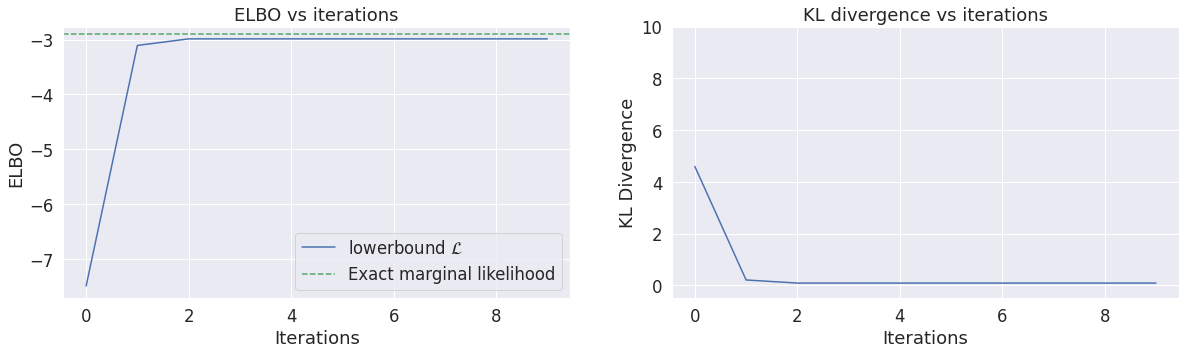

In [54]:
def bernoulli_entropy(p):
    """ computes the entropy of a Bernoulli random variable Ber(p) """
    return -(1-p)*np.log(1-p)  - p*np.log(p)

def gauss_entropy(m, v):
    """ computes the entropy of a Gaussian random variable N(m, v) """
    return 0.5*np.log(2*np.pi*v*np.exp(1))


def evaluate_elbo(t, phat, mhat, vhat):
    
    t1 = -0.5*np.log(2*np.pi*sigma2) - 1/(2*sigma2)*(t**2 + mhat**2*phat+vhat*phat - 2*t*mhat*phat )
    t2 = (1-phat)*np.log(1-p0) + phat*np.log(p0)
    t3 = -0.5*np.log(2*np.pi*kappa2) - 1/(2*kappa2)*(mhat**2 + vhat)
    t4 = bernoulli_entropy(phat)
    t5 = gauss_entropy(mhat, vhat)
    
    return t1+t2+t3+t4+t5

# data and hyperparameters
sigma2 = 0.1
kappa2 = 1
p0 = 0.2
t = 1

# evaluate ELBO as a function of iterations
max_itt = 10
elbos = np.zeros(max_itt)
for itt in range(max_itt):
    phat, mhat, vhat = fit_approximation(t, p0, sigma2, kappa2, max_itt=itt, conv_tol=1e-10)
    elbos[itt] = evaluate_elbo(t, phat, mhat, vhat)

# compute exact marginal likelihood
log_exact = np.log(marginal_likelihood(t, p0, sigma2, kappa2))


fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(elbos, label='lowerbound $\mathcal{L}$')
axes[0].set(xlabel='Iterations', ylabel='ELBO', title='ELBO vs iterations')
axes[0].axhline(log_exact, linestyle='--', color='g', label='Exact marginal likelihood')
axes[0].legend()
axes[1].plot(log_exact - elbos)
axes[1].set(xlabel='Iterations', ylabel='KL Divergence', title='KL divergence vs iterations', ylim=(-0.5, 10));


***Task 11***: Complete the implementation of the two functions for computing the entropy a Bernoulli and a Gaussian random variable above.

**Questions**

1) Explain what you see in the figure. What is the relationship between the blue curves in the two plots?

2) How is the KL divergence computed? and why can we do this in this example?

### Appendix: Complete calculation of ELBO


The evidence lower bound for this model can be found by a rather long, but straight-forward calculation

$$
\begin{align*}
\mathcal{L}\left[q\right] &= \mathbb{E}_{q(s)q(w)} \left[\ln p(t|s, w)p(s)p(w) \right] - \mathbb{E}_{q(s)q(w)} \left[ \ln q(s)q(w) \right]\\
%
&= \mathbb{E}_{q(s)q(w)} \left[\ln p(t|s, w) \right] + \mathbb{E}_{q(s)q(w)} \left[ \ln p(s) \right] + \mathbb{E}_{q(s)q(w)} \left[ \ln p(w) \right] - \mathbb{E}_{q(s)q(w)} \left[ \ln q(s) \right] -  \mathbb{E}_{q(s)q(w)} \left[ q(w) \right]\\
%
&= \mathbb{E}_{q(s)q(w)} \left[\ln p(t|s, w) \right] + \mathbb{E}_{q(s)} \left[ \ln 
p(s) \right] + \mathbb{E}_{q(w)} \left[ \ln p(w) \right] - \mathbb{E}_{q(s)} \left[ \ln q(s) \right] -  \mathbb{E}_{q(w)} \left[ \ln q(w) \right]
\end{align*}
$$

The terms $- \mathbb{E}_{q(s)} \left[ \ln q(s) \right]$ and $-  \mathbb{E}_{q(w)} \left[ \ln q(w) \right]$ are the **entropy** of $q(s)$ and $q(w)$, respectively.

Let's calculate all terms. The first term

$$
\begin{align*}
\mathbb{E}_{q(s)q(w)} \left[\ln p(t|s, w) \right] &= \mathbb{E}_{q(s)q(w)} \left[-\frac{1}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2}(t-sw)^2 \right]\\
%
&= \mathbb{E}_{q(s)q(w)} \left[-\frac{1}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2}(t^2 + s^2w^2-2tsw) \right]\\
%
&= \mathbb{E}_{q(s)q(w)} \left[-\frac{1}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2}(t^2 + s^2w^2-2tsw) \right]\\
%t
&= -\frac{1}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2}(t^2 + \mathbb{E}_{q(s)} \left[s^2\right]\mathbb{E}_{q(w)} \left[w^2\right]-2t\mathbb{E}_{q(s)} \left[s\right]\mathbb{E}_{q(w)} \left[w\right])\\
%
&= -\frac{1}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2}(t^2 + \hat{p}(\hat{m}^2 + \hat{v})-2t\hat{p}\hat{m})\\
%
\end{align*}
$$

The second term

$$
\begin{align}
 \mathbb{E}_{q(s)} \left[ \ln p(s) \right] = q(s=0)\ln p(s=0) + q(s=1) \ln p(s=1) &= (1-\hat{p})\ln(1-p_0) + \hat{p}\ln(p_0)
\end{align}
$$

The third term


$$
\begin{align*}
 \mathbb{E}_{q(w)} \left[ \ln p(w) \right] &= \mathbb{E}_{q(w)} \left[ -\frac{1}{2}\ln(2\pi\kappa^2) - \frac{1}{2\kappa^2}w^2\right]\\
 %
 &=   -\frac{1}{2}\ln(2\pi\kappa^2) - \frac{1}{2\kappa^2}\mathbb{E}_{q(w)} \left[w^2\right]\\
 %
 &=   -\frac{1}{2}\ln(2\pi\kappa^2) - \frac{1}{2\kappa^2}\left(\hat{m}^2 + \hat{v}\right)
\end{align*}
$$

The fourth term (-negative entropy of $q(s)$) is given by

$$
\begin{align*}
 \mathbb{E}_{q(s)} \left[ \ln q(s) \right] = q(s=0)\ln q(s=0) + q(s=1) \ln q(s=1) &= (1-\hat{p})\ln(1-\hat{p}) + \hat{p}\ln(\hat{p})
\end{align*}
$$

The last term is the (negative) posterior entropy of $w$


$$
\begin{align*}
 \mathbb{E}_{q(w)} \left[ \ln q(w) \right] &= \mathbb{E}_{q(w)} \left[ -\frac{1}{2}\ln(2\pi\hat{v}) - \frac{1}{2\hat{v}}(w-\hat{m})^2\right]\\
 %
 &= -\frac{1}{2}\ln(2\pi\hat{v}) - \frac{1}{2\hat{v}} \mathbb{E}_{q(w)} \left[(w-\hat{m})^2\right]\\
 %
 &= -\frac{1}{2}\ln(2\pi\hat{v}) - \frac{1}{2\hat{v}} \mathbb{E}_{q(w)} \left[w^2 + \hat{m}^2 - 2w\hat{m}\right]\\
 %
 &= -\frac{1}{2}\ln(2\pi\hat{v}) - \frac{1}{2\hat{v}}  \left(\hat{m}^2 + \hat{v} + \hat{m}^2 - 2\hat{m}^2\right)\\
 %
 &= -\frac{1}{2}\ln(2\pi\hat{v}) - \frac{1}{2}\\
 %
 &= -\frac{1}{2}\ln(2\pi\hat{v}) - \frac{1}{2}\ln(e)\\
 &= -\frac{1}{2}\ln(2\pi e\hat{v})
\end{align*}
$$

Putting everything together yields

$$
\begin{align*}
\mathcal{L}\left[q\right] &= -\frac{1}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2}(t^2 + \hat{p}(\hat{m}^2 + \hat{v})-2t\hat{p}\hat{m}) + (1-\hat{p})\ln(1-p_0) + \hat{p}\ln(p_0)  -\frac{1}{2}\ln(2\pi\kappa^2) - \frac{1}{2\kappa^2}\left(\hat{m}^2 + \hat{v}\right) - (1-\hat{p})\ln(1-\hat{p}) - \hat{p}\ln(\hat{p}) + \frac{1}{2}\ln(2\pi e\hat{v})
\end{align*}
$$